In [1]:
# Adds SIFT and SURF functionalities.
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/")

In [2]:
from pathlib import Path
import os
import pandas as pd
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin

# Utilities

In [3]:
import time

class codeTimer:
    """
    Context manager, measures and prints the execution time of a function.
    """
    
    def __init__(self, name=None):
        self.name = "Executed '"  + name + "'. " if name else ""

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, exc_type, exc_value, traceback):
        self.end = time.perf_counter()
        self.elapsed = (self.end - self.start)
        print('%s Elapsed time: %0.6fs' % (str(self.name), self.elapsed))

# Read and compute descriptors

In [4]:
# Read image and directory (image category)

def read_image(dir_path):
    """
    TBD iterator
    """
    
    for subdir, dirs, files in os.walk(dir_path):
        for file in files:
            # Ignore useless files.
            if file != ".DS_Store":
                yield (cv2.imread(os.path.join(subdir, file)),
                       os.path.basename(subdir))
                

def compute_descriptors(dir_path):
    """
    TBD, note on ORB instead of SIFT/SURF
    """
    
    # Lists to contain data.
    image_ids = []
    descriptors = []
    labels = []
    
    # Build ORB object.
    orb = cv2.xfeatures2d.SIFT_create()
    
    image_id = 0
    
    for image, label in read_image(dir_path):
        # Detect and compute keypoints.
        kp, des = orb.detectAndCompute(image, None)
        # If no keypoints detected, continue.
        if kp == []:
            continue
        for d in range(len(des)):
            descriptors.append(des[d])
            image_ids.append(image_id)
            labels.append(label)
            
        image_id += 1
            
    des_df = pd.DataFrame(columns = ['image_id', 'descriptor', 'label'])
    des_df['image_id'] = image_ids
    des_df['descriptor'] = descriptors
    des_df['label'] = labels
    
    
    return des_df

# Kmeans and historgams

In [5]:
def k_means_words(descriptors_df, n_clusters, num_descriptors):
    """
    TBD
    """
    
    # Sample `num_descriptors` descriptors.
    data = descriptors_df['descriptor'].sample(n = num_descriptors).tolist()
    # Compute the kmeans algorithm on the sampled descriptors.
    kmeans = KMeans(n_clusters = n_clusters, n_jobs = -1).fit(data)
    return kmeans

In [6]:
def find_nearest_term(word, dictionary):
    """
    TBD
    """
    distances = [lin.norm(word - term) for term in dictionary]
    
    return np.argmin(distances)

def compute_histogram(descriptors_df, kmeans):
    """
    TBD
    """
    # Estract visual words (centroids) from kmeans computation.
    words = kmeans.cluster_centers_
    
    descriptor_dim = len(words)
    num_images = len(descriptors_df['image_id'])
    
    histograms = np.zeros((num_images, descriptor_dim))
    
    # For every image.
    for index, row in descriptors_df.iterrows():
        # For every descriptor.
        for descriptor in row['descriptor']:
            closest_centroid = find_nearest_term(descriptor, words)
            histograms[index][closest_centroid] += 1
            
    # Compute norms and normalisation.
    norm = np.sum(histograms, axis = 1).reshape(num_images, 1)
    histograms = histograms / norm
    
    # More convenient format as list of arrays.
    histograms = list(histograms[row] for row in range(len(histograms)))
    
    return histograms

# Classifiers

In [7]:
from scipy.stats import wasserstein_distance

def nn_classifier(train_df, test_df):
    true_labels = test_df['label']
    predicted_labels = []
    
    # For each test image.
    for test_index, test_row in test_df.iterrows():
        distances = []
        # Compute distance with each train image.
        for train_index, train_row in train_df.iterrows():
            distances.append(wasserstein_distance(train_row['histogram'],
                                                  test_row['histogram']))
        # The predicted label corresponds to the minimum distance.
        predicted_labels.append(train_df.iloc[np.argmin(distances)]['label'])
        
    return true_labels, predicted_labels

In [ ]:
from sklearn.svm import SVC

def linear_SVM_classifier(train_df, test_df):
    
    true_labels = test_df['label']
    predicted_labels = []
    
    # Training multiclass SVM, one-vs-rest approach.
    
    # Extract labels.
    train_labels = train_df['label'].to_numpy()
    classes = train_df['label'].unique()

    # Extract histograms, (n_samples, n_feature) numpy array.
    histo = np.asarray(train_df['histogram'].tolist())

    # Build a classifier for each class.
    clf = [SVC(kernel = 'linear') for _ in range(len(classes))]

    # Fit each of the classifiers.
    for idx, c in enumerate(clf):
        current_label = classes[idx]
        # 1 for current_label occurrences, -1 elsewhere.
        target = np.array(["1" if  label == current_label else "-1" for label in train_labels])
        c = c.fit(histo, target)
        
    # Predicting label for each test image.
    
    for test_index, test_row in test_df.iterrows():
        distances = []
        # Compute real valued score with each classifier.
        for idx, c in enumerate(clf):
            # Compute distances from hyperplanes
            distances.append(c.decision_function(test_row['histogram'].reshape(1, -1) / 
                                                 lin.norm(c.coef_)))
        # The predicted label corresponds to the maximum distance from hyperplane.
        predicted_labels.append(classes[np.argmax(distances)])
    
    
    return true_labels, predicted_labels

# Main

In [8]:
train_path = "./dataset/train"
test_path = "./dataset/test"

n_clusters = 25 # Size of dictionary.
n_descriptors = 100000

# Read images and compute descriptors, saving them in a dataframe.
with codeTimer("Compute descriptors"):
    train_df = compute_descriptors(train_path)

Executed 'Compute descriptors'.  Elapsed time: 46.490912s


In [9]:
train_df.head()

,image_id,descriptor,label
0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Industrial
1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Industrial
2,0,"[0.0, 0.0, 2.0, 18.0, 7.0, 1.0, 0.0, 0.0, 54.0...",Industrial
3,0,"[0.0, 0.0, 4.0, 8.0, 3.0, 0.0, 0.0, 0.0, 137.0...",Industrial
4,0,"[64.0, 53.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 153...",Industrial


In [10]:
# Compute kmeans clustering using descriptors
# Note: cluster centers are stored in this object,
# and can be obtained using `kmeans.cluster_centers_`.
with codeTimer("Compute k-means words"):
    kmeans = k_means_words(train_df, n_clusters, n_descriptors)

Executed 'Compute k-means words'.  Elapsed time: 75.425109s


In [11]:
# Aggregate descriptor info, making dataframe more compact.
# Now the third column contains the list of descriptors.
train_df = train_df.groupby(['image_id', 'label'],
                            as_index = False).agg({'descriptor':
                                                   (lambda x: list(x))})

In [12]:
# Compute histograms and add them to dataframe.
with codeTimer("Compute histograms"):
    train_histograms = compute_histogram(train_df, kmeans)
    
train_df['histogram'] = train_histograms

Executed 'Compute histograms'.  Elapsed time: 156.569561s


In [13]:
# Compute histograms for test set, using words extracted from train.

test_df = compute_descriptors(test_path)

test_df = test_df.groupby(['image_id', 'label'],
                            as_index = False).agg({'descriptor':
                                                   (lambda x: list(x))})

# Note, kmeans has not been recomputed, the training one is used.
test_histograms = compute_histogram(test_df, kmeans)
test_df['histogram'] = test_histograms

In [14]:
test_df.head()

,image_id,label,descriptor,histogram
0,0,Industrial,"[[6.0, 39.0, 118.0, 87.0, 10.0, 4.0, 2.0, 1.0,...","[0.013927576601671309, 0.05013927576601671, 0...."
1,1,Industrial,"[[8.0, 20.0, 9.0, 7.0, 3.0, 1.0, 0.0, 6.0, 36....","[0.01276595744680851, 0.02553191489361702, 0.0..."
2,2,Industrial,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.036458333333333336, 0.050347222222222224, 0..."
3,3,Industrial,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0,...","[0.05263157894736842, 0.02631578947368421, 0.0..."
4,4,Industrial,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0...","[0.051643192488262914, 0.035211267605633804, 0..."


----
## NN

In [ ]:
with codeTimer("NN classifier"):
    true, predicted = nn_classifier(train_df, test_df)
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

In [ ]:
# Storing results to file
#test_df.to_pickle("test_frame")
#train_df.to_pickle("train_frame")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
conmat = confusion_matrix(true, predicted)
conmat = conmat / np.sum(conmat, axis = 1)
sn.heatmap(conmat)

In [ ]:
np.sum(np.diag(conmat)) / np.sum(conmat)

----
## SVM

In [20]:
with codeTimer("Linear SVM classifier"):
    true, predicted = linear_SVM_classifier(train_df, test_df)
    
# Adding predicted lables to dataframe.
test_df["predicted"] = predicted

Executed 'Linear SVM classifier'.  Elapsed time: 6.597790s


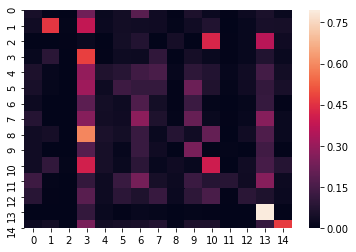

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
conmat = confusion_matrix(true, predicted)
conmat = conmat / np.sum(conmat, axis = 1)
sn.heatmap(conmat)

In [26]:
np.sum(np.diag(conmat)) / np.sum(conmat)

0.21397181033147109

----
## OTHER

In [ ]:
img = cv2.imread("./dataset/train/Coast/image_0231.jpg")
orb = cv2.xfeatures2d.SIFT_create()
kp = orb.detect(img,None)
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img,kp,img)
plt.imshow(img2),plt.show()

In [ ]:
len(des)

In [ ]:
des